In [1]:
library("IBMPopSim")
library("ggplot2")
library("Rcpp")
library(dplyr)
library(gridExtra)


Attaching package: ‘IBMPopSim’


The following object is masked from ‘package:stats’:

    stepfun



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
# Generate initial population
N <- 100000  # Number of individuals in the initial population

In [3]:
# xb - xd is distributed uniformly on -10 ,10
xd <- runif(N,0,10)
pop_init <- data.frame(
  "birth" = rep(0,N), 
  "death" = as.double(NA),
  "Lansing" = rep(c(TRUE,TRUE),N/2),
    "xb"= 10-xd, 
    "xd" =  xd, 
    "lignee"=1:N
)
get_characteristics(pop_init)


Lansing       xb       xd   lignee 
  "bool" "double" "double"    "int"

In [4]:
head(pop_init)
#plot.ecdf(pop_init$xb-pop_init$xd)

,birth,death,Lansing,xb,xd,lignee
,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<int>
1,0,NA,TRUE,5.834449,4.1655506,1
2,0,NA,TRUE,2.167940,7.8320603,2
3,0,NA,TRUE,8.192680,1.8073196,3
4,0,NA,TRUE,6.802818,3.1971822,4
5,0,NA,TRUE,7.331736,2.6682644,5
6,0,NA,TRUE,9.105202,0.8947978,6


In [5]:
# Events and model creation
 # There are 2 possible events :

# - Birth (with or without mutation)
# - Death

# Each event is characterized by its intensity and  kernel code, described below.

## Birth event with individual intensity

### Parameters



In [6]:
params_birth <- list("ib"= 1, "p"=0.1 , "var_mut"=0.05)

In [7]:

birth_event <- mk_event_individual( type = "birth",
  intensity_code = ' if (age(I,t) < I.xb)
                        result = ib; 
                    else 
                        result =0;',  # each individual  I can give birth at rate ib if its age is less than xb
  kernel_code = 'if (CUnif() < p)
                     newI.xb = max(0., CNorm(I.xb, var_mut)); 
                 else
                     newI.xb = I.xb;
                if (I.Lansing & (age(I,t)> I.xd) & (age(I,t)<I.xb))
                     newI.xd =0;
                 else{
                    if (CUnif()<p)
                        newI.xd =max(0., CNorm(I.xd, var_mut));
                     else 
                        newI.xd =I.xd;}
                 newI.Lansing =I.Lansing;
                 newI.lignee =I.lignee;') 
# An individual I can give birth to an individual newI. The kernel code defines characteristics of individual newI
# Attention la manière dont est calculée le trait après mutation est un peu différente du code du Tristan

In [8]:
## Death event 
### parameters
params_death <- list("intens"=1, "compet"= 0.0009)

In [9]:
## Deaths due to interactions
death_event1 <- mk_event_interaction(name='death1',
  type = "death",
  interaction_code = "result = compet;" 
)

In [10]:
## Deaths due to aging 
death_event2 <- mk_event_individual(name='death2', type="death",
                  intensity_code = ' if (age(I,t)>I.xd) result= intens; 
                                     else result =0;')

In [11]:
# Model creation 
model <- mk_model(
  characteristics = get_characteristics(pop_init),
  events = list(birth_event, death_event1, death_event2),
  parameters = c(params_birth, params_death)

)
summary(model)

Events:
#1: individual event of type birth
#2: interaction event of type death
#3: individual event of type death
--------------------------------------- 
Individual description:
names:  birth death Lansing xb xd lignee 
R types:  double double logical double double integer 
C types:  double double bool double double int
--------------------------------------- 
R parameters available in C++ code:
names:  ib p var_mut intens compet 
R types:  double double double double double 
C types:  double double double double double

In [12]:
## Bounds for birth and death rates 

birth_intensity_max <- params_birth$ib
interaction_fun_max <- params_death$compet
death2_max <- params_death$intens

In [13]:
T = 1500 # Simulation end time 


sim_out <- popsim(model = model,
  population = pop_init,
  events_bounds = c('birth'=birth_intensity_max, 'death1'=interaction_fun_max,'death2'= death2_max),
  parameters = c(params_birth, params_death),
  time = T)

Simulation on  [0, 1500] 

In [14]:
# Simulation with different parameters

#The model can be simulated with different parameters without being recompiled.


In [15]:
#sim_out$logs["duration_main_algorithm"]
#sim_out$logs

In [16]:
# Outputs

In [17]:
str(sim_out$population)

'data.frame':	1748260 obs. of  6 variables:
 $ birth  : num  1494 1494 1495 1495 1495 ...
 $ death  : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Lansing: logi  TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ xb     : num  6.41 5.27 5.44 5.43 5.48 ...
 $ xd     : num  6.25 5.07 5.29 5.23 5.23 ...
 $ lignee : int  5686 5686 5686 5686 5686 5686 5686 5686 5686 5686 ...


In [18]:
pop_out <- sim_out$population
head(pop_out)

,birth,death,Lansing,xb,xd,lignee
,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<int>
1,1493.997,NA,TRUE,6.406507,6.246731,5686
2,1494.161,NA,TRUE,5.274830,5.066872,5686
3,1494.688,NA,TRUE,5.443304,5.288574,5686
4,1494.692,NA,TRUE,5.429180,5.234345,5686
5,1494.800,NA,TRUE,5.480258,5.233166,5686
6,1494.841,NA,TRUE,5.596497,5.141098,5686


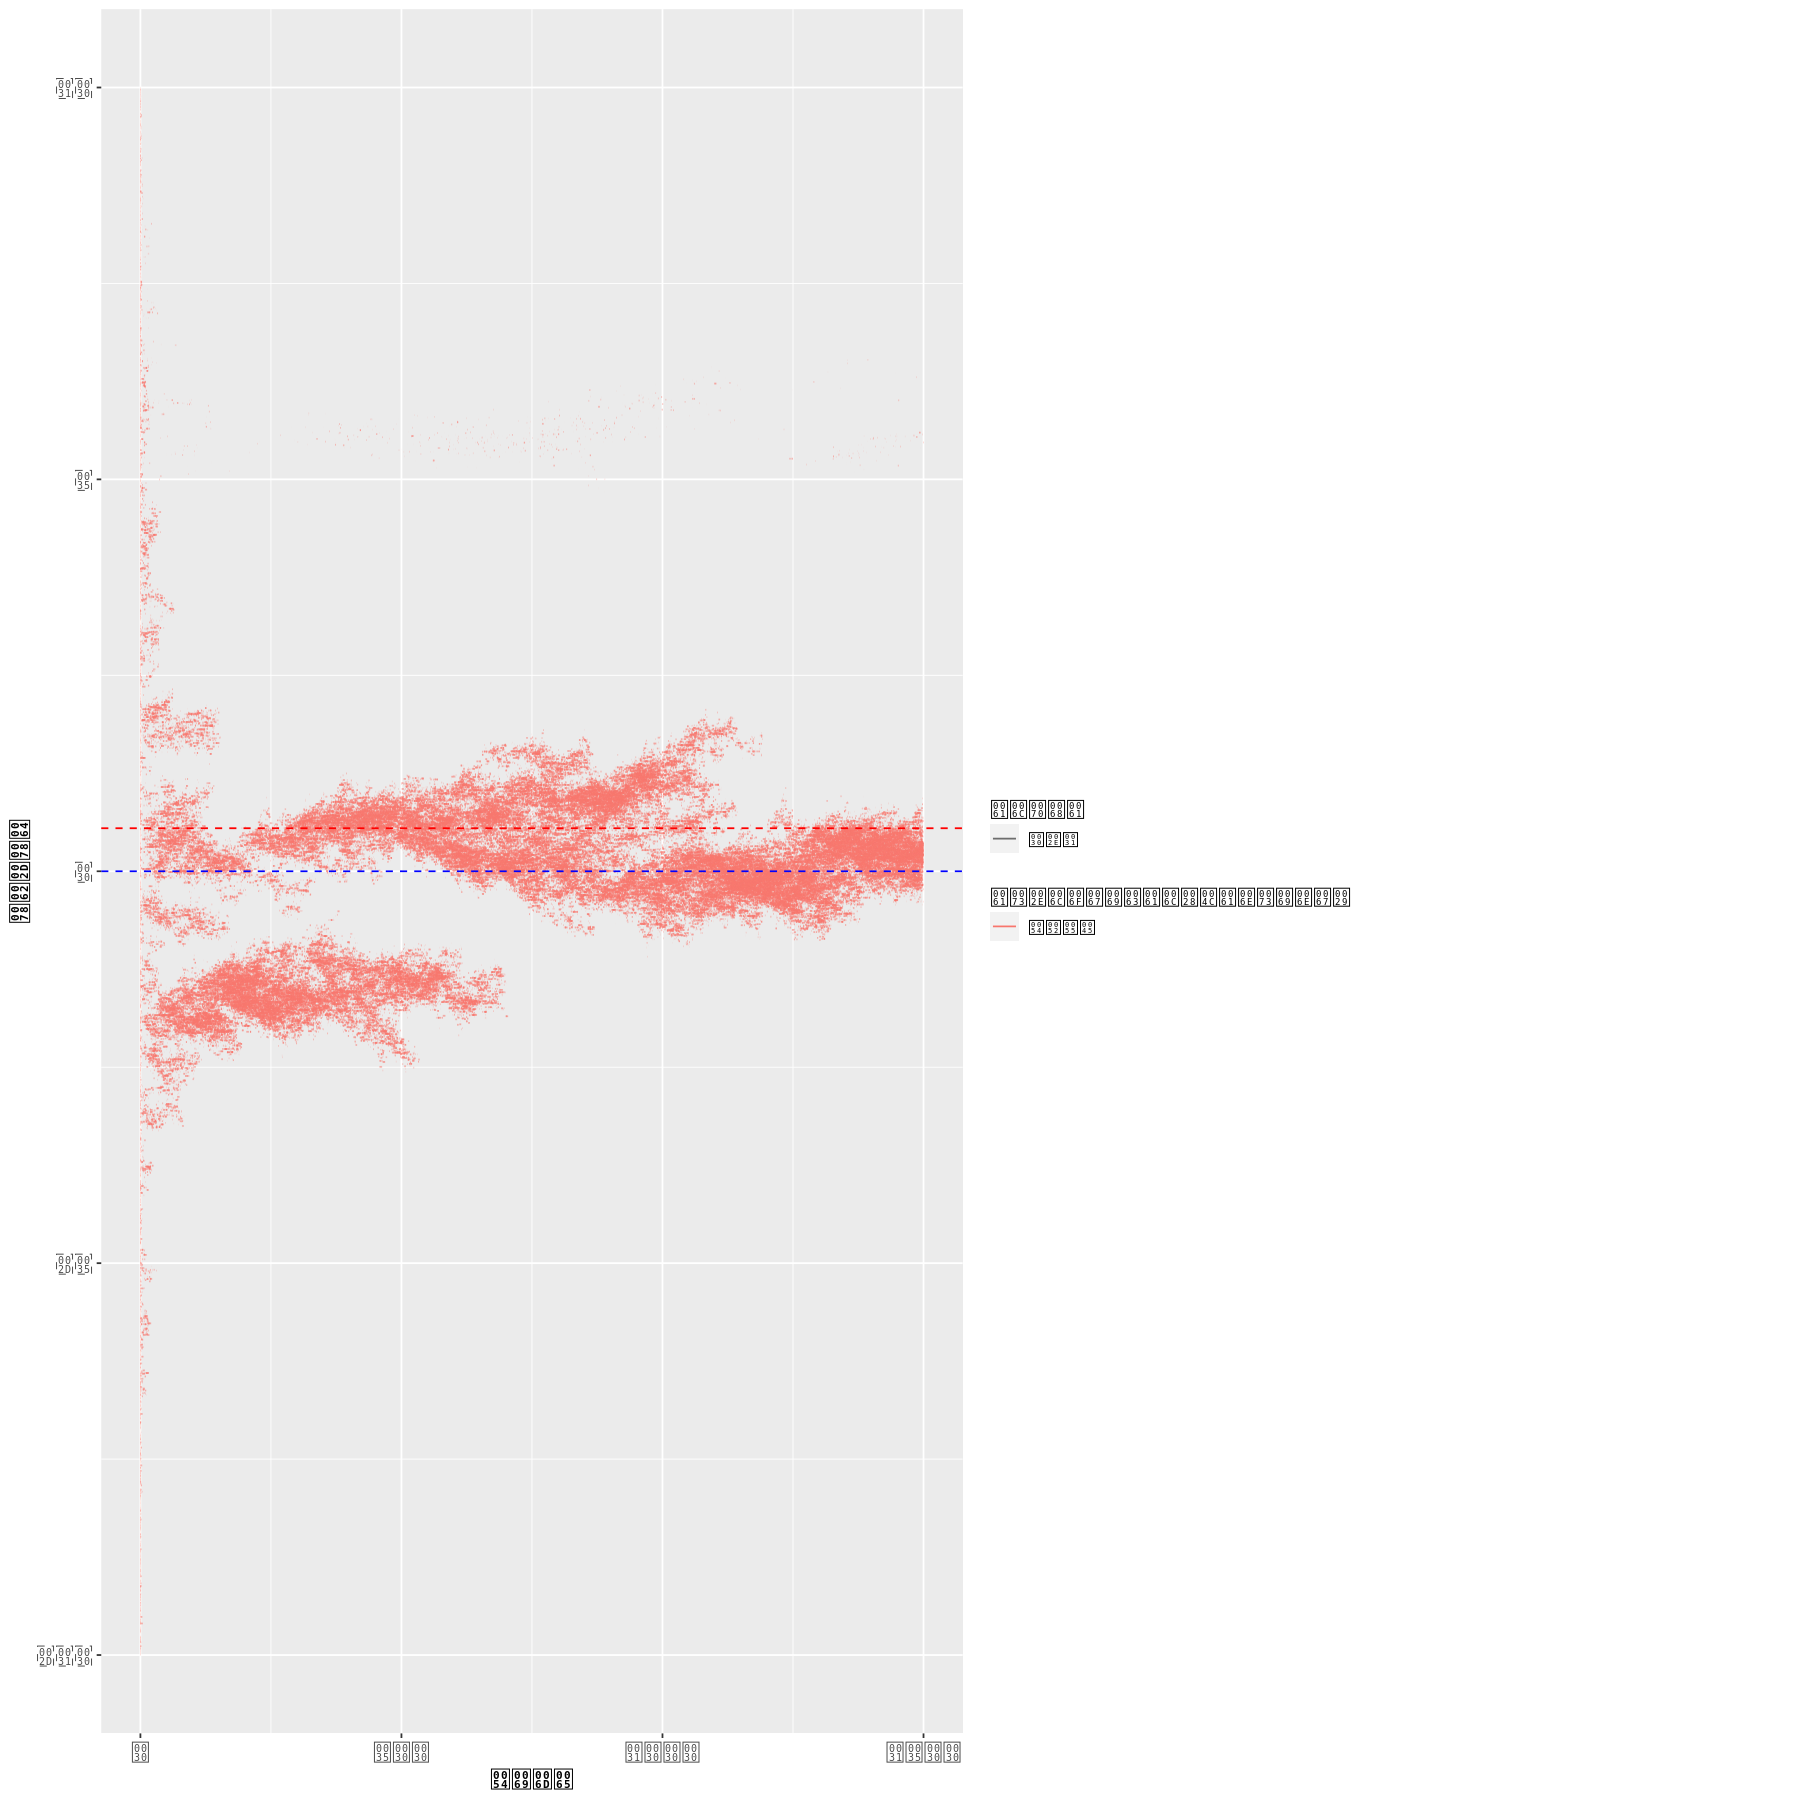

In [19]:
options(repr.plot.width=15, repr.plot.height=15)
xbxd_evol_for_publi <- ggplot(pop_out %>% sample_n(300000), aes(color=as.logical(Lansing), alpha = 0.1)) + 
  geom_segment(aes(x=birth, xend=death, y=xb-xd, yend=xb-xd, alpha =0.1) , na.rm=TRUE)+
  xlab("Time") +
  ylab("xb-xd") + 
  geom_hline(yintercept=log(3)/2, color = "red", linetype="dashed") +
  geom_hline(yintercept = 0, color = "blue", linetype="dashed") +
  #theme(legend.position="none")+
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))

xbxd_evol_for_publi

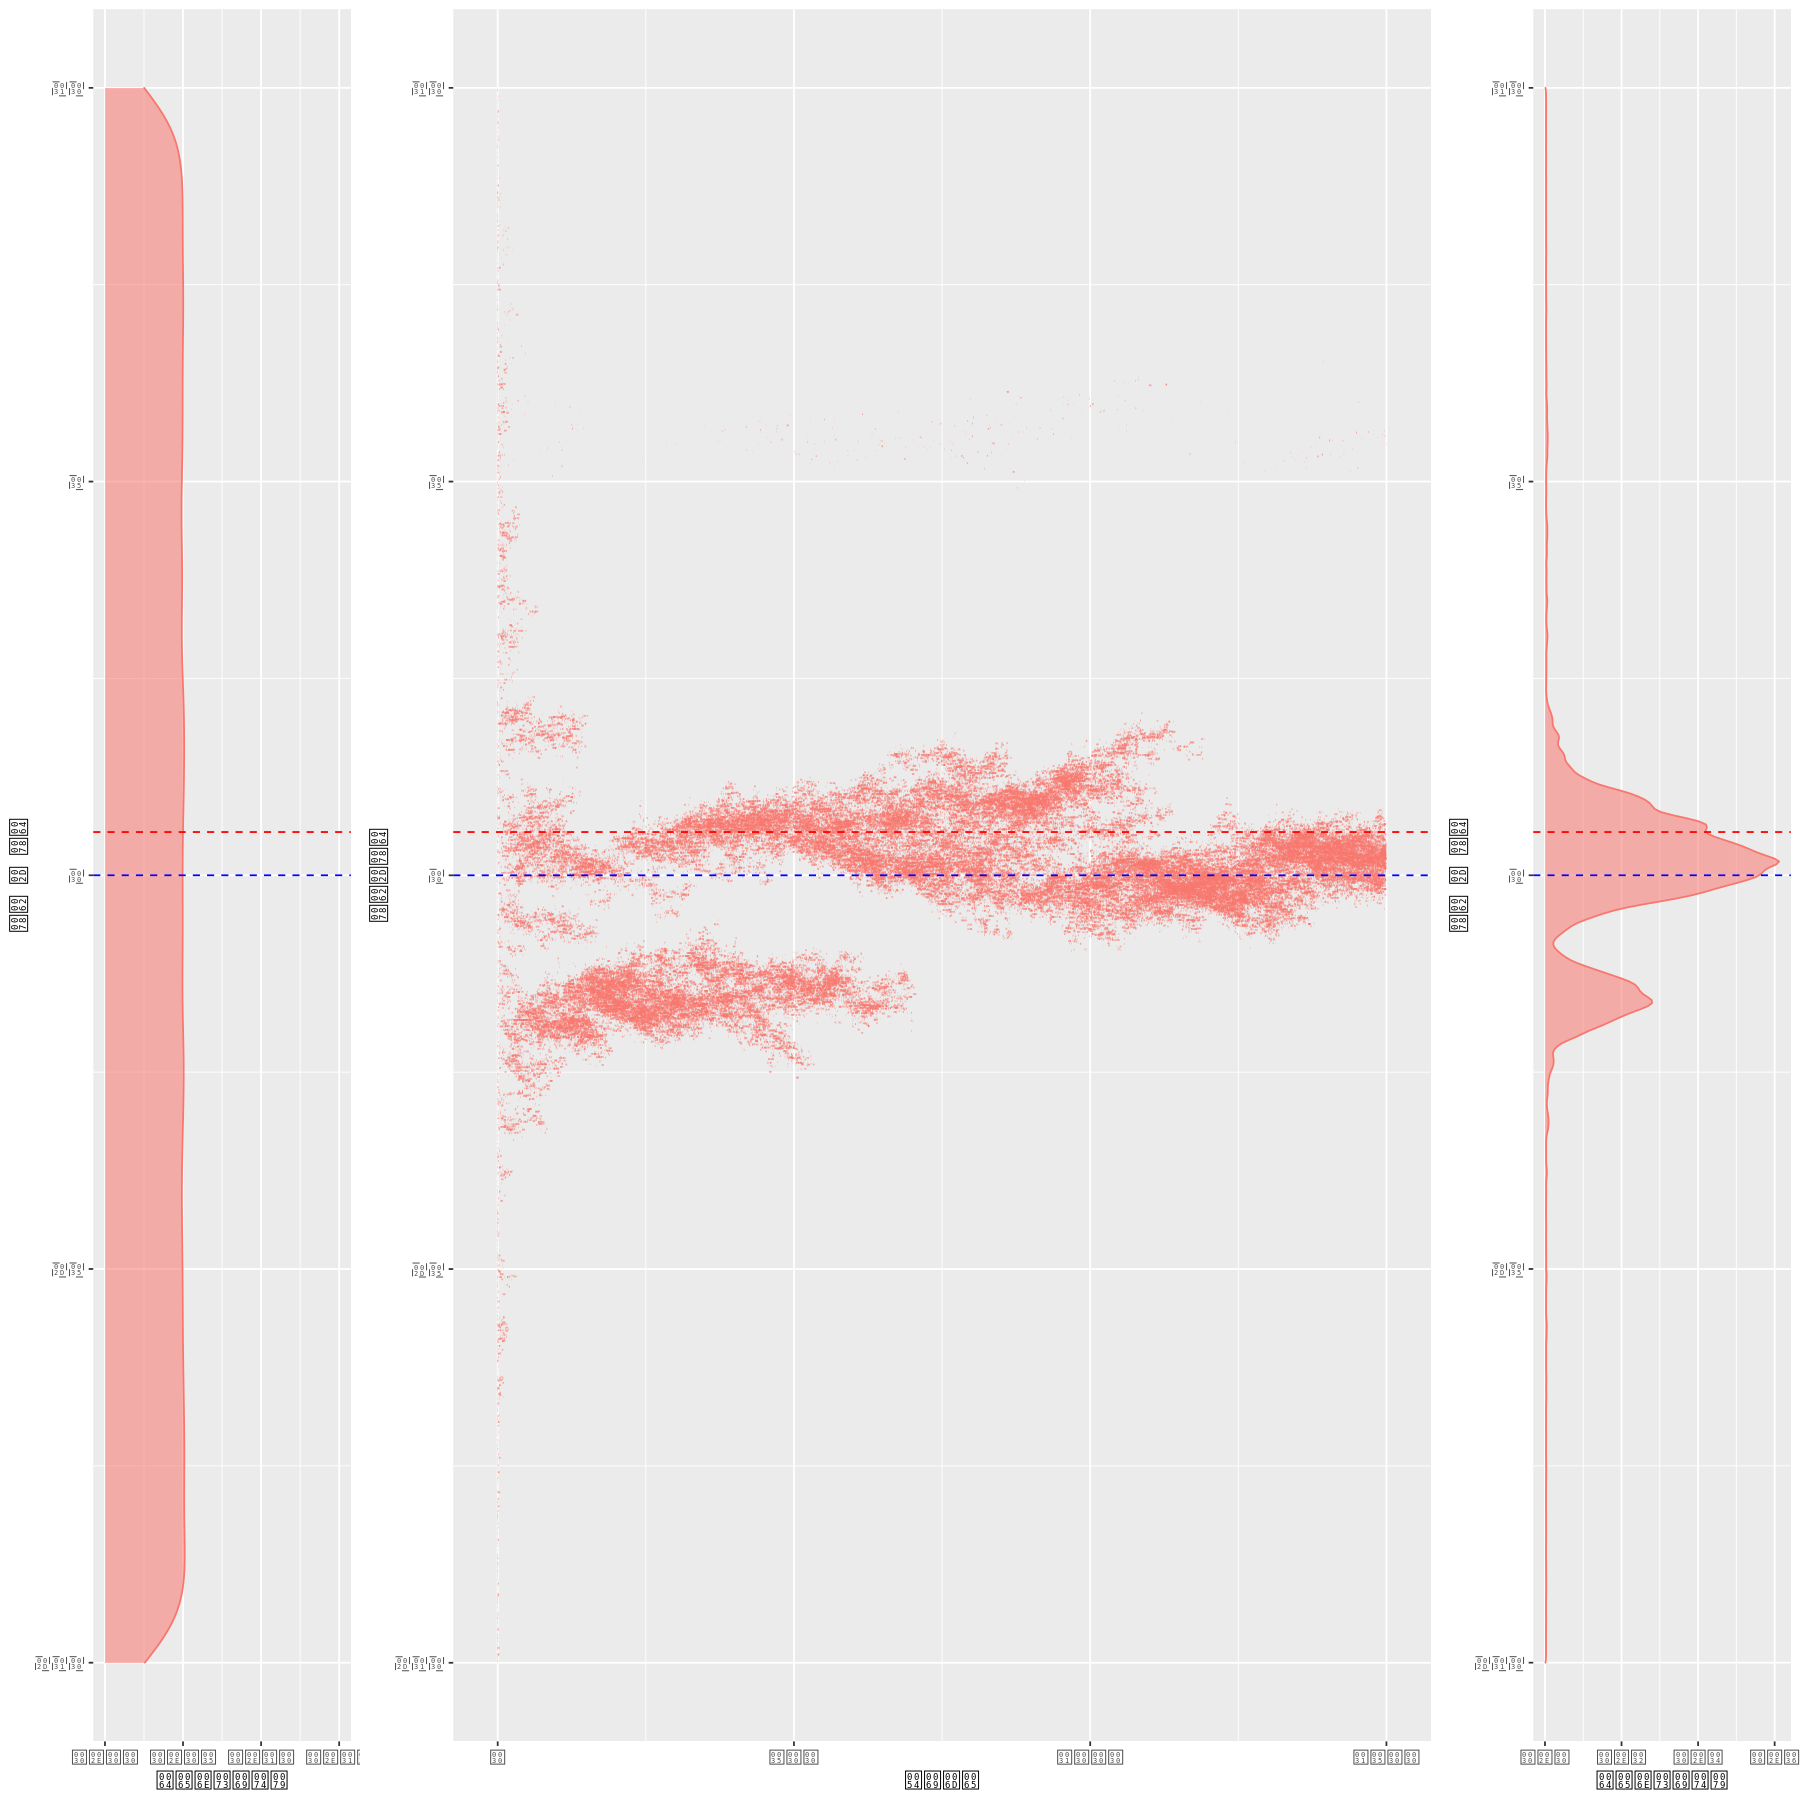

In [20]:
t0density <-  ggplot(pop_out %>% filter(birth==0), aes(x=xb-xd, color=Lansing, fill=Lansing, height=..scaled.., alpha = 0.1)) + 
                geom_density() + 
                geom_vline(xintercept = 0, color = "blue", linetype="dashed")  +
                geom_vline(xintercept = log(3)/2, color = "red", linetype="dashed") +
                ylim(0,0.15) + 
                coord_flip() +
                theme(legend.position="none")

soldensity <- ggplot(pop_out, aes(x=xb-xd, color=Lansing, fill=Lansing, height=..scaled.., alpha = 0.1)) + 
                geom_density() + 
                geom_vline(xintercept = 0, color = "blue", linetype="dashed")  +
                geom_vline(xintercept = log(3)/2, color = "red", linetype="dashed") +
                coord_flip() +
                xlim(-10,10) +
                theme(legend.position="none")

xbxd_evol <- ggplot(pop_out  %>% sample_n(200000), aes(color=as.logical(Lansing))) + 
                geom_segment(aes(x=birth, xend=death, y=xb-xd, yend=xb-xd, alpha =0.1) , na.rm=TRUE)+
                xlab("Time") +
                ylab("xb-xd") + 
                geom_hline(yintercept=log(3)/2, color = "red", linetype="dashed") +
                geom_hline(yintercept = 0, color = "blue", linetype="dashed") +
                theme(legend.position="none")

p = grid.arrange(t0density, xbxd_evol, soldensity, ncol=3, nrow = 1, widths=c(2,6,2))

In [ ]:
#calculation of Malthusian parameters (Newton's method)
deriv_2 <- function(f, x, y, dx){
  return((f(x+dx, y)-f(x, y))/dx)
}
deriv_3 <- function(f, x, y, z, dx){
  return((f(x+dx, y, z)-f(x, y, z))/dx)
}
F <- function(a, b){
  u = 0
  if(a == 0){u = b - 1}
  else{u = ((1/a)*(1-exp(-a*b)))-1}
  return(u)
}
H <- function(a, b, d){
  u = 0
  if(a == 0){ u = d - exp(d-b)}
  else{u = ((1-exp(-a*d))/a) + (exp(d)/(1+a))*(exp(-d*(1+a))-exp(-b*(1+a)))-1}
  return(u)
}
G <- function(a, d){
  u = 0
  if(a == 0){u = d - 1}
  else{u = ((1/a)*(1-exp(-a*d)))-1}
  return(u)
}
malthus_nl <- function(b, d, x_0, epsilon, delta){
  if(b<=d){
    u = x_0
    while(abs(F(u, b))>epsilon){
      u = u - (F(u, b)/deriv_2(F, u, b, delta))
    }
    return(u)
  } else {
    v = x_0
    while((abs(H(v,b,d))>epsilon)){
      v = v - (H(v, b, d)/deriv_3(H, v, b, d, delta))
    }
    return(v)
  }
}
malthus_l <- function(b, d, x_0, epsilon, delta){
  if(b<=d){
    u = x_0
    while(abs(F(u, b))>epsilon){
      u = u - (F(u, b) / deriv_2(F, u, b, delta))
    }
    return(u)
  } else {
    v = x_0
    while(abs(G(v, d))>epsilon){
      v = v - (G(v, d) / deriv_2(G, v, d, delta))
    }
    return(v)
  }
}
x_0 = 0.5; epsilon = 0.00001; delta = 0.000001; u = 0

In [ ]:
t=seq(0, round(max(pop_out$birth)))
pop_out_mod <- pop_out %>% mutate(Malthus = ifelse(Lansing==TRUE,malthus_l(xb, xd, x_0, epsilon, delta),malthus_nl(xb, xd, x_0, epsilon, delta)))
fun = function(t){
    pop_t <- population_alive(pop_out_mod, t) 
    pop_t_L <- pop_t %>% filter(Lansing)
    pop_t_nL <- pop_t %>% filter(!Lansing)
    rbind(t, pop_t_L %>% count(), pop_t_L[,7] %>% median(na.rm=TRUE), pop_t_nL%>% count(), pop_t_nL[,7]  %>% median(na.rm=TRUE))
} 
surv_table <- as.data.frame(t(matrix(unlist(cbind(lapply(t, fun))),5)))
colnames(surv_table) <- c("time", "Lansing", "mean_Malthus_L","nonLansing", "mean_Malthus_nL")
max_pop <- surv_table %>% filter(time > 5) %>% select(Lansing, nonLansing) %>% max()
max_pop
head(surv_table)

In [ ]:
 ggplot(surv_table) + 
  geom_line(aes(x=time, y=Lansing), color = "#00BDD0" )+
  geom_line(aes(x=time, y=nonLansing), color = "#F8766D" ) +
  ylim(0, max_pop)+
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))

In [ ]:
 ggplot(surv_table) + 
  geom_line(aes(x=time, y=mean_Malthus_L), color = "#00BDD0" )+
  geom_line(aes(x=time, y=mean_Malthus_nL), color = "#F8766D" ) +
  #ylim(0, 1)+
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))